# Loading the data

C:\Users\pc\AppData\Local\Temp\ipykernel_9720\4273651758.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_9720\4273651758.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_cols = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


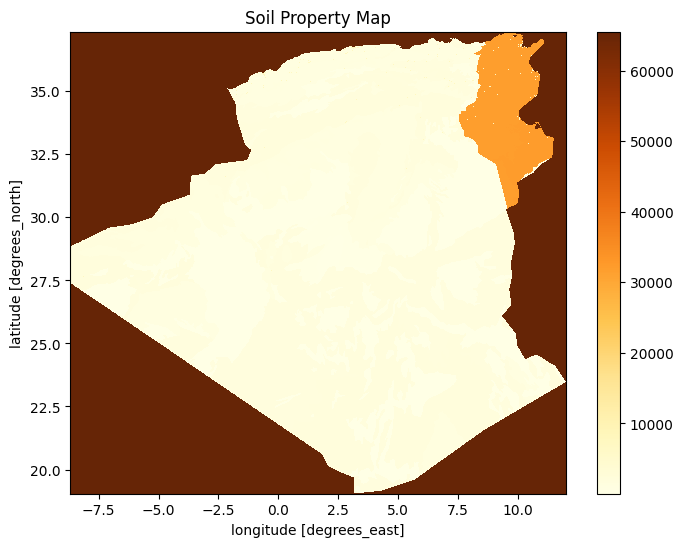

In [68]:
import pyodbc
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_smu_ids(countries):
    countries = world[world["NAME"].isin(countries)]

    # ensure CRS match
    countries = countries.to_crs(rds.rio.crs)

    # clip raster to Algeria + Tunisia
    clipped = rds.rio.clip(countries.geometry, from_disk=True)
    # print("Clipping done.")
    transform = clipped.rio.transform()

    # Get pixel indices (ignore band dimension)
    rows, cols = np.indices(clipped.shape[1:])

    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    # print("Coordinate extraction done.")
    lons = np.array(xs).flatten()
    lats = np.array(ys).flatten()

    # Flatten raster values
    smu_ids = clipped.values.flatten()

    # Remove NaN values
    mask = ~np.isnan(smu_ids)
    # print("NaN removal done.")

    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    # print("DataFrame creation done.")
    return df, clipped
def filter_smu_layers(smu_ids):
    # Filter to selected SMU_IDs
    layers_filtered = all_cols[all_cols["HWSD2_SMU_ID"].isin(smu_ids)]

    return layers_filtered

mdb_path = r"../local_dataset/raw/soil/HWSD2.mdb"
conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    f"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
all_cols = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
world = gpd.read_file(r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp")
raster_path = r"../local_dataset/raw/soil/HWSD2.bil"
rds = rioxarray.open_rasterio(raster_path)


smu_ids, clipped_rds = extract_smu_ids(["Algeria", "Tunisia"])
# smu_ids = (
#     smu_ids.groupby("HWSD2_SMU_ID")[["lon", "lat"]]
#     .mean()  # centroid per SMU
#     .reset_index()
# )

# print("SMU ID extraction complete.")

all_cols = filter_smu_layers(smu_ids["HWSD2_SMU_ID"])
# print("Layer filtering complete.")

all_cols = all_cols[all_cols["LAYER"] == "D1"]
useful_columns = [
    "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND",
]
all_cols = all_cols[useful_columns]
all_cols["TEXTURE_SOTER"] = all_cols["TEXTURE_SOTER"].replace(["-"], np.nan)

clipped_rds = clipped_rds.squeeze("band", drop=True)
clipped_rds.plot(cmap="YlOrBr", robust=True, figsize=(8, 6))
plt.title("Soil Property Map")
plt.show()


# Analysis part

In [69]:
import math

print(f"Shape {all_cols.shape}")
print("=== Data types per column ===")
print(all_cols.dtypes)

Shape (858, 22)
=== Data types per column ===
COARSE             int64
SAND               int64
SILT               int64
CLAY               int64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL           int64
CEC_CLAY           int64
CEC_EFF          float64
TEB              float64
BSAT               int64
ALUM_SAT           int64
ESP                int64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND          int64
dtype: object


# Missing values in each column 

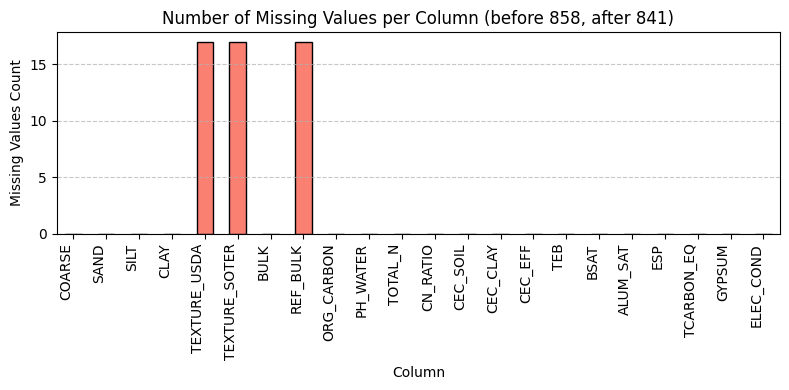

In [70]:

def plot_missing_values(all_cols):
    missing_values_percentage = all_cols.isnull().sum()
    old_number_of_rows = all_cols.shape[0]
    plt.figure(figsize=(8,4))
    missing_values_percentage.plot(kind='bar', color='salmon', edgecolor='black')
    new_number_of_rows = all_cols.dropna().shape[0]

    plt.title(f"Number of Missing Values per Column (before {old_number_of_rows}, after {new_number_of_rows})")
    plt.ylabel("Missing Values Count")
    plt.xlabel("Column")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_missing_values(all_cols)


# Fixing Missing values 

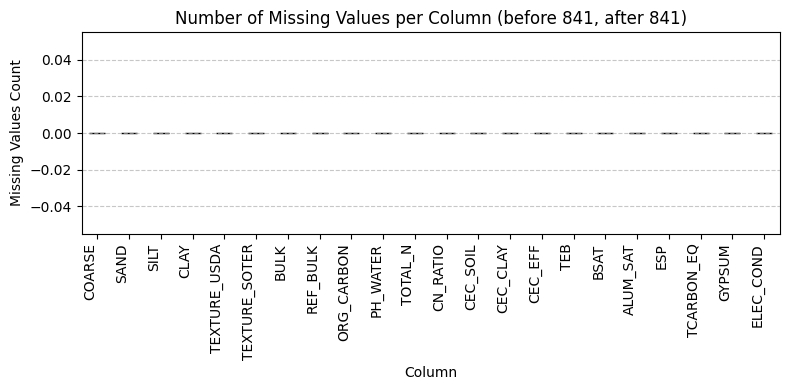

In [ ]:
numeric_cols = all_cols.select_dtypes(include=['number'])
numeric_cols = numeric_cols.fillna(numeric_cols.mean())
all_cols.update(numeric_cols)
all_cols = all_cols.dropna() # Remove rows with string missing values
numeric_cols = all_cols.select_dtypes(include=['number'])
plot_missing_values(all_cols)

# Univariate Analysis

In [72]:
print("=== Univariate Analysis === ")
print(f"=== Mean ===\n{numeric_cols.mean()}")
print(f"===  Standard Deviation ===\n{numeric_cols.std()}")
print(f"===  Minimum ===\n{numeric_cols.min()}")
print(f"===  Maximum ===\n{numeric_cols.max()}")
print(f"===  Median ===\n{numeric_cols.median()}")

=== Univariate Analysis === 
=== Mean ===
COARSE          12.095125
SAND            48.092747
SILT            30.180737
CLAY            21.726516
TEXTURE_USDA     8.971463
BULK             1.429251
REF_BULK         1.714614
ORG_CARBON       0.929611
PH_WATER         7.700000
TOTAL_N          0.960190
CN_RATIO         9.978597
CEC_SOIL        15.744352
CEC_CLAY        59.463734
CEC_EFF         37.032105
TEB             36.038050
BSAT            93.432818
ALUM_SAT         0.512485
ESP              6.984542
TCARBON_EQ       9.367658
GYPSUM           4.522949
ELEC_COND        2.211653
dtype: float64
===  Standard Deviation ===
COARSE           9.775966
SAND            14.326248
SILT             7.655105
CLAY             9.763214
TEXTURE_USDA     2.422935
BULK             0.107109
REF_BULK         0.131226
ORG_CARBON       0.673056
PH_WATER         0.677425
TOTAL_N          0.435237
CN_RATIO         1.521127
CEC_SOIL         7.174196
CEC_CLAY        14.711639
CEC_EFF         23.125335
TEB  

# Unique numeric values in integer column 

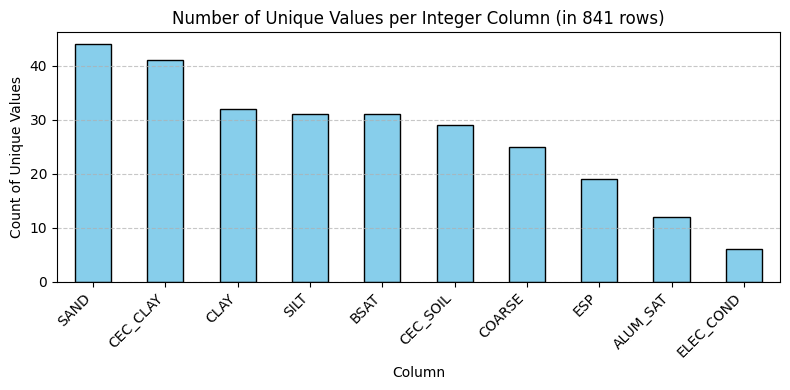

In [73]:

int_cols = numeric_cols.select_dtypes(include="int")
unique_values = int_cols.nunique().sort_values(ascending=False)

plt.figure(figsize=(8,4))
unique_values.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title(f"Number of Unique Values per Integer Column (in {all_cols.shape[0]} rows)")
plt.ylabel("Count of Unique Values")
plt.xlabel("Column")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Value distribution and outliers for numeric columns

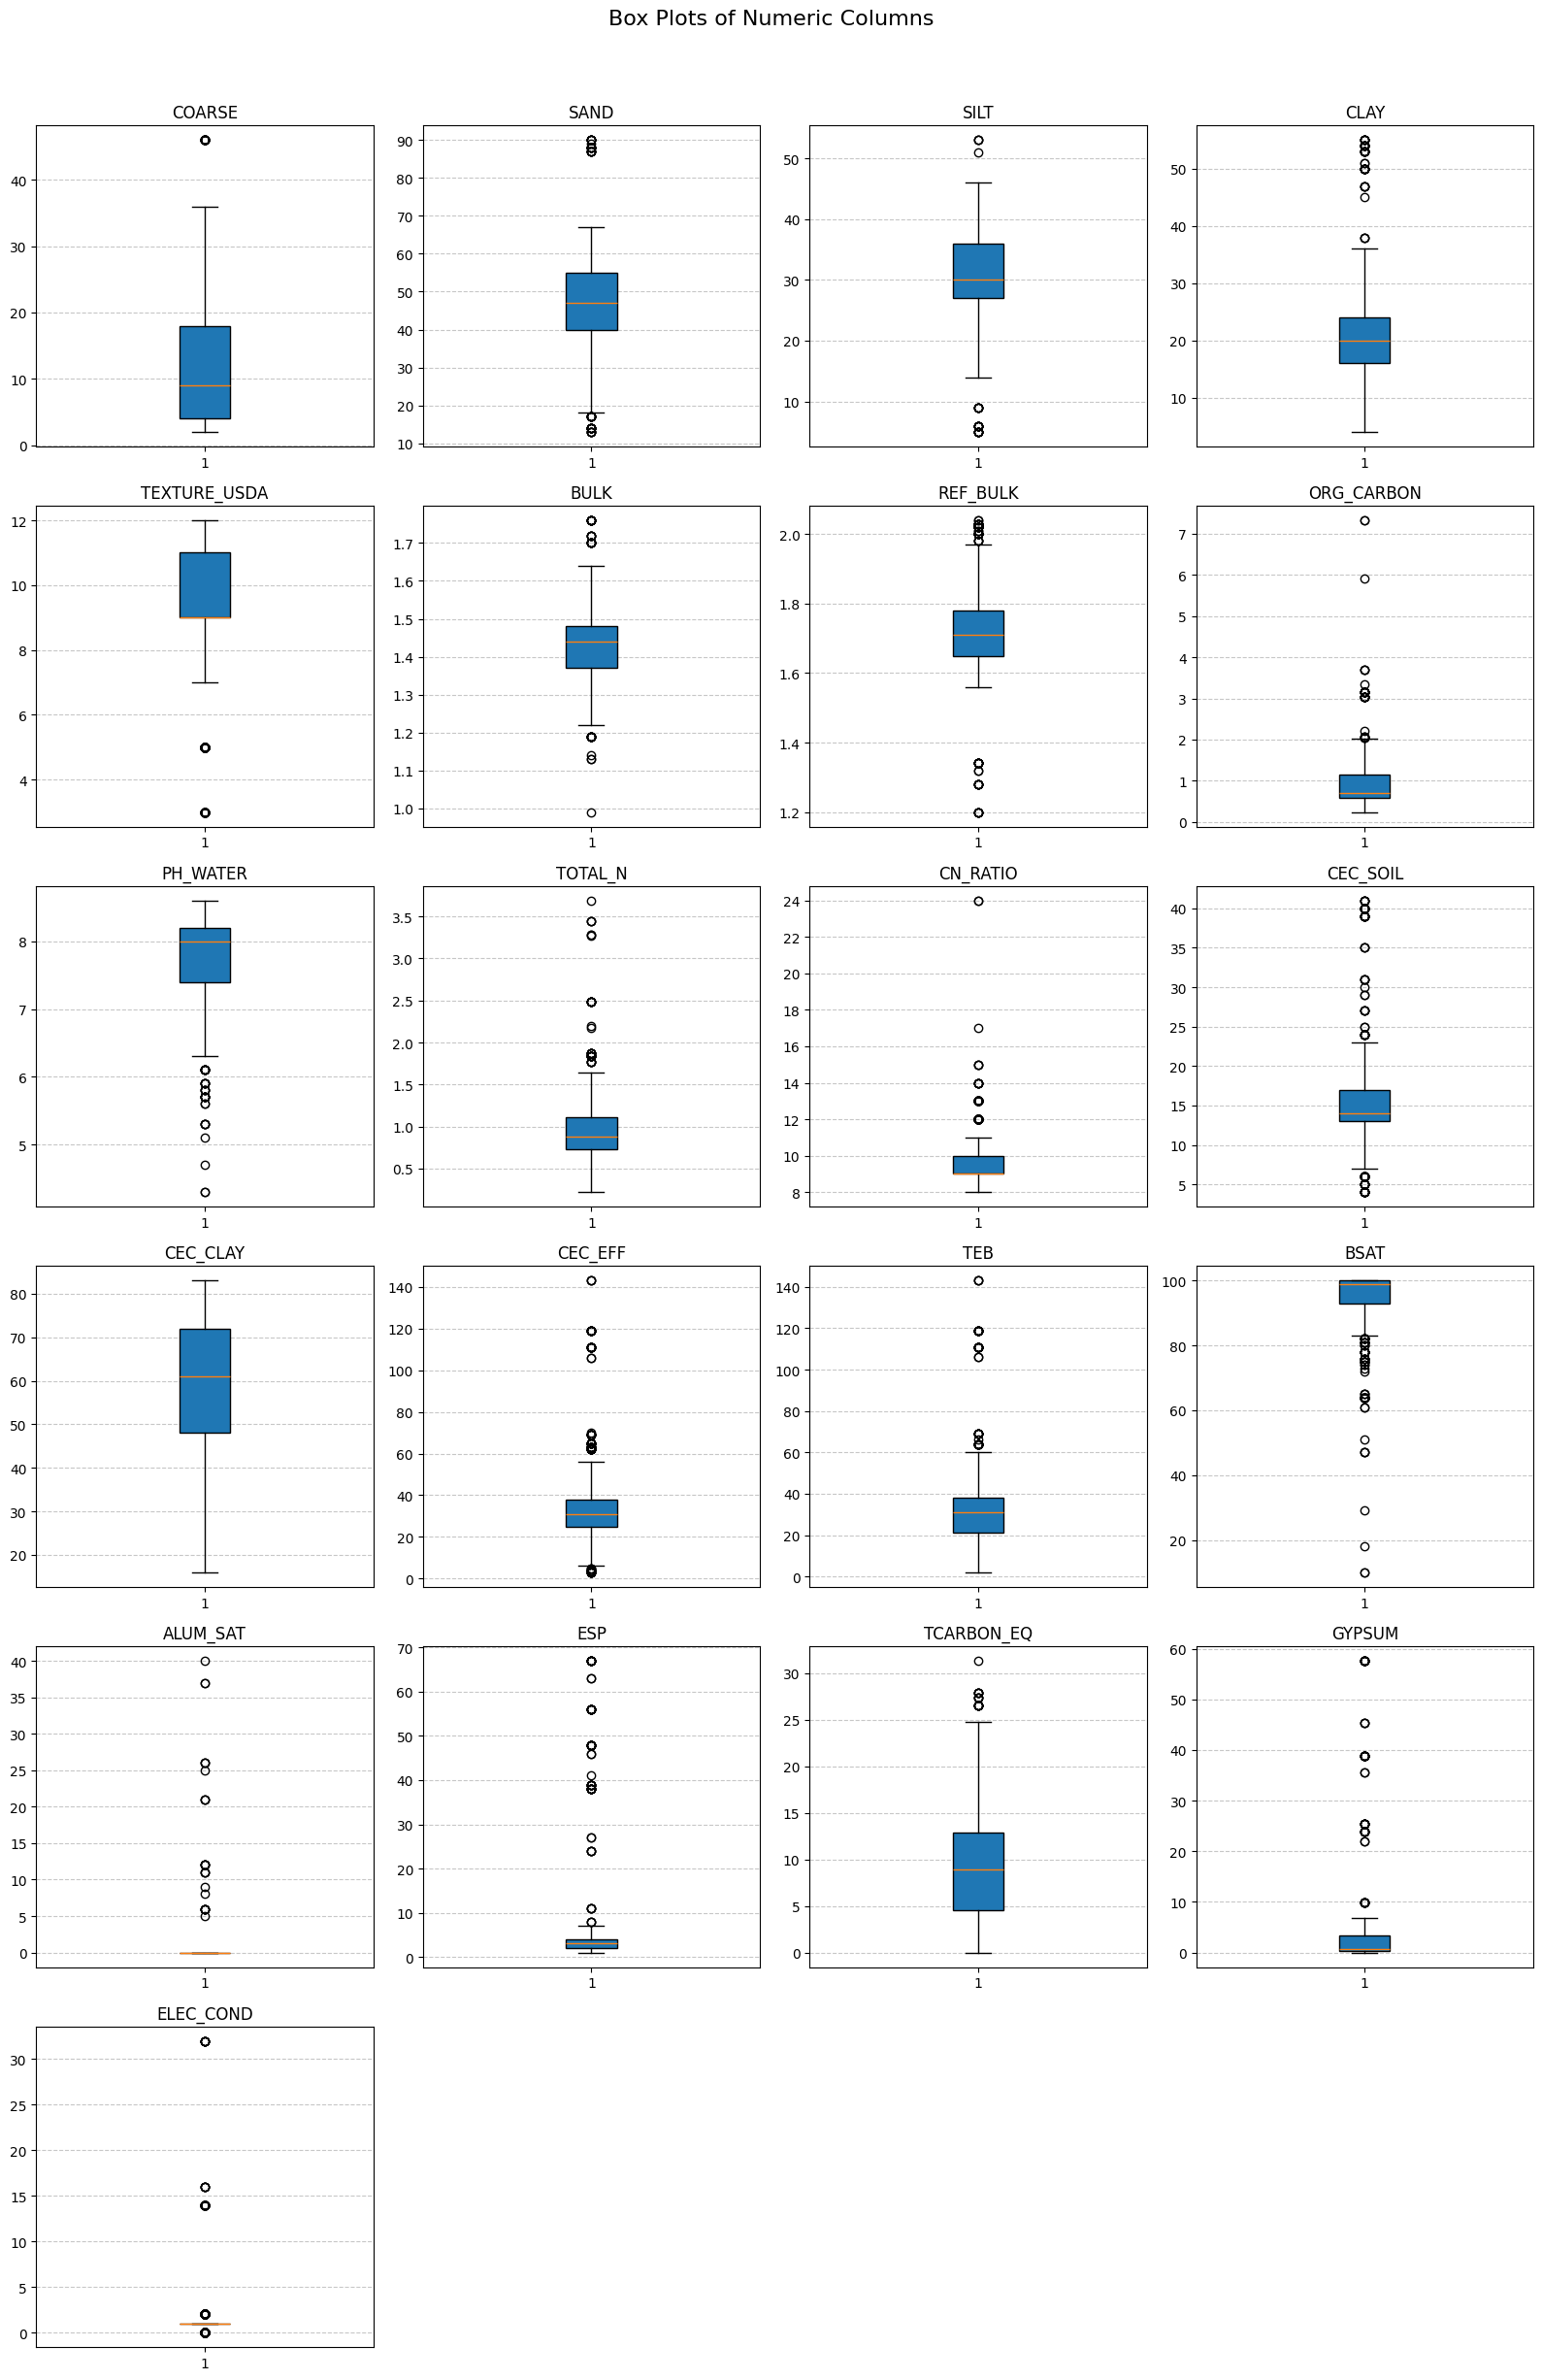

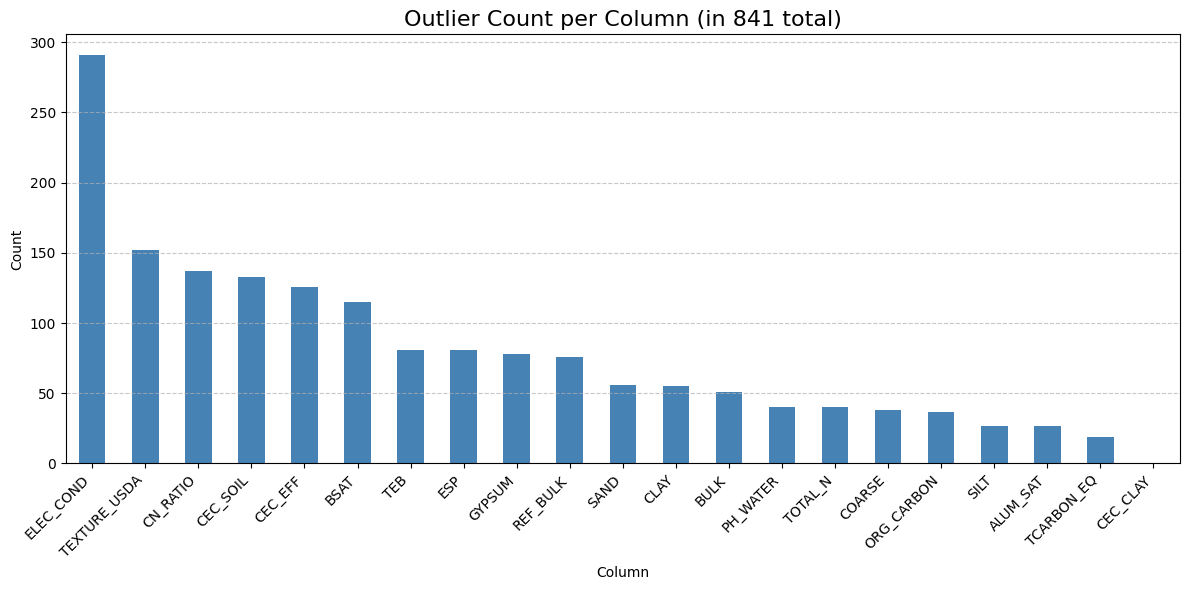

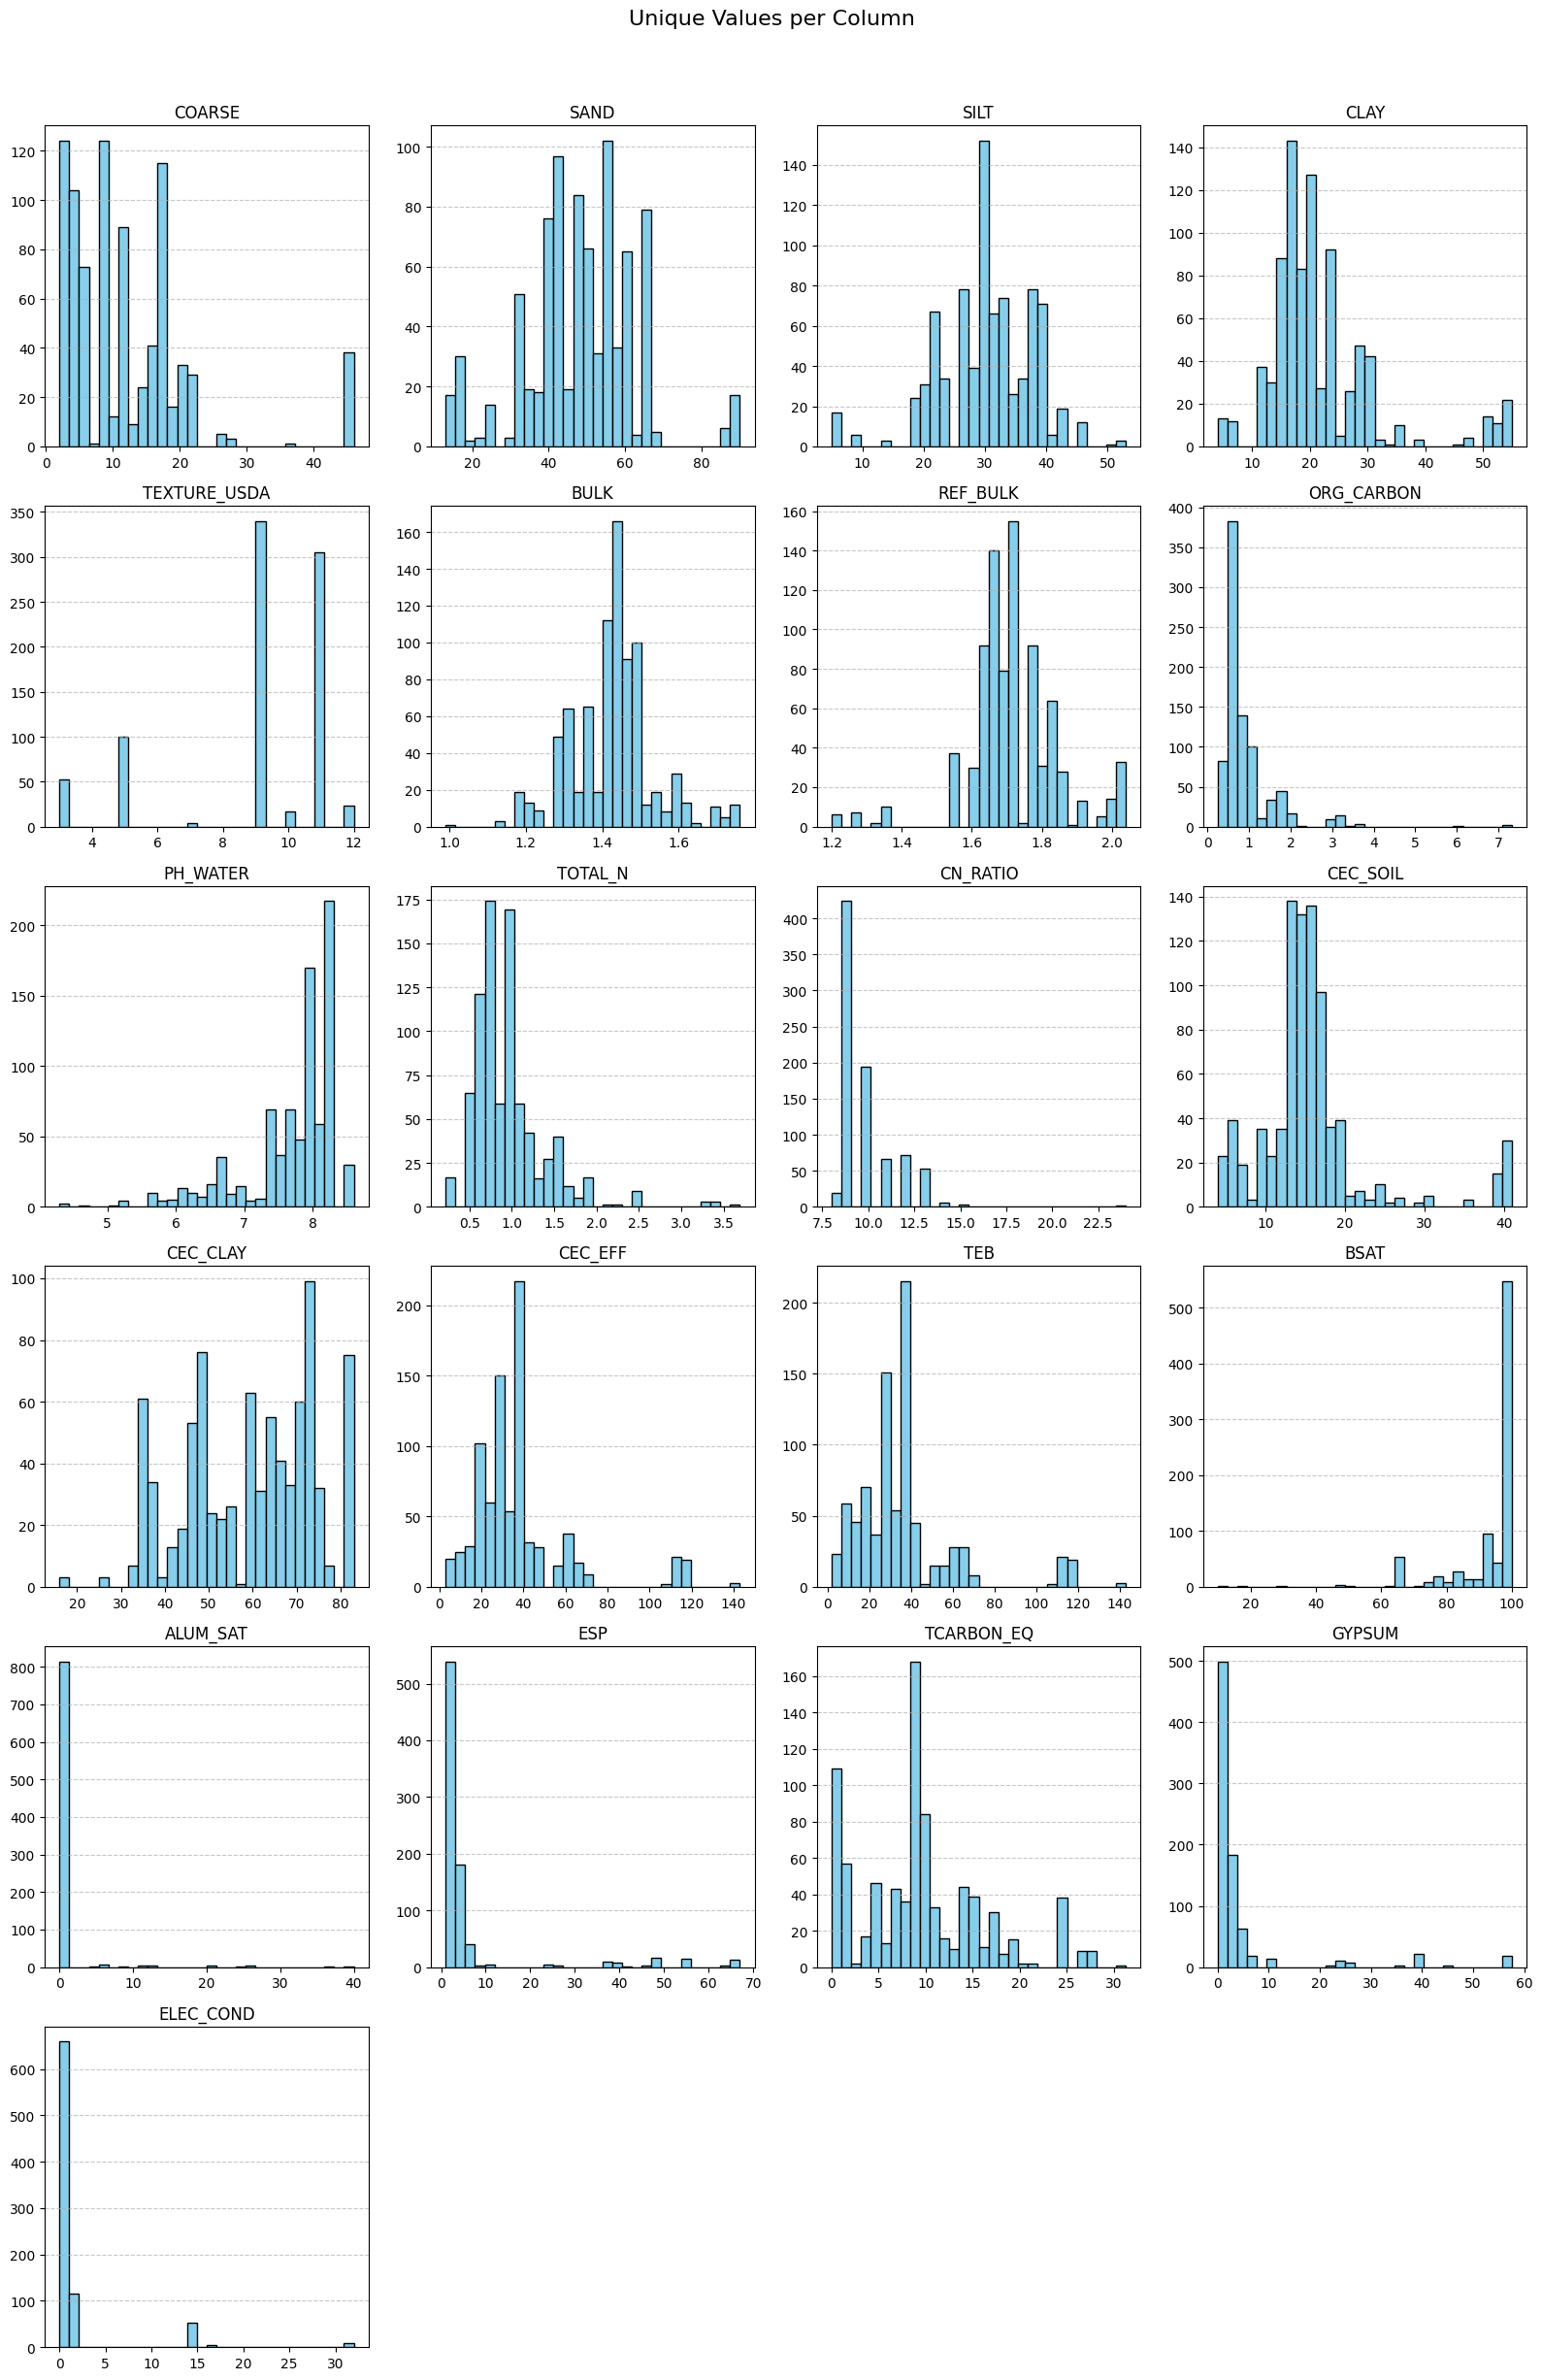

In [74]:

cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_box_plots(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_box_plots(numeric_cols)





Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
outlier_counts.plot(kind="bar", color="steelblue")
plt.title(f"Outlier Count per Column (in {len(numeric_cols)} total)", fontsize=16)
plt.xlabel("Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()




def plot_histograms(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_histograms(numeric_cols)

# Fixing Outliers

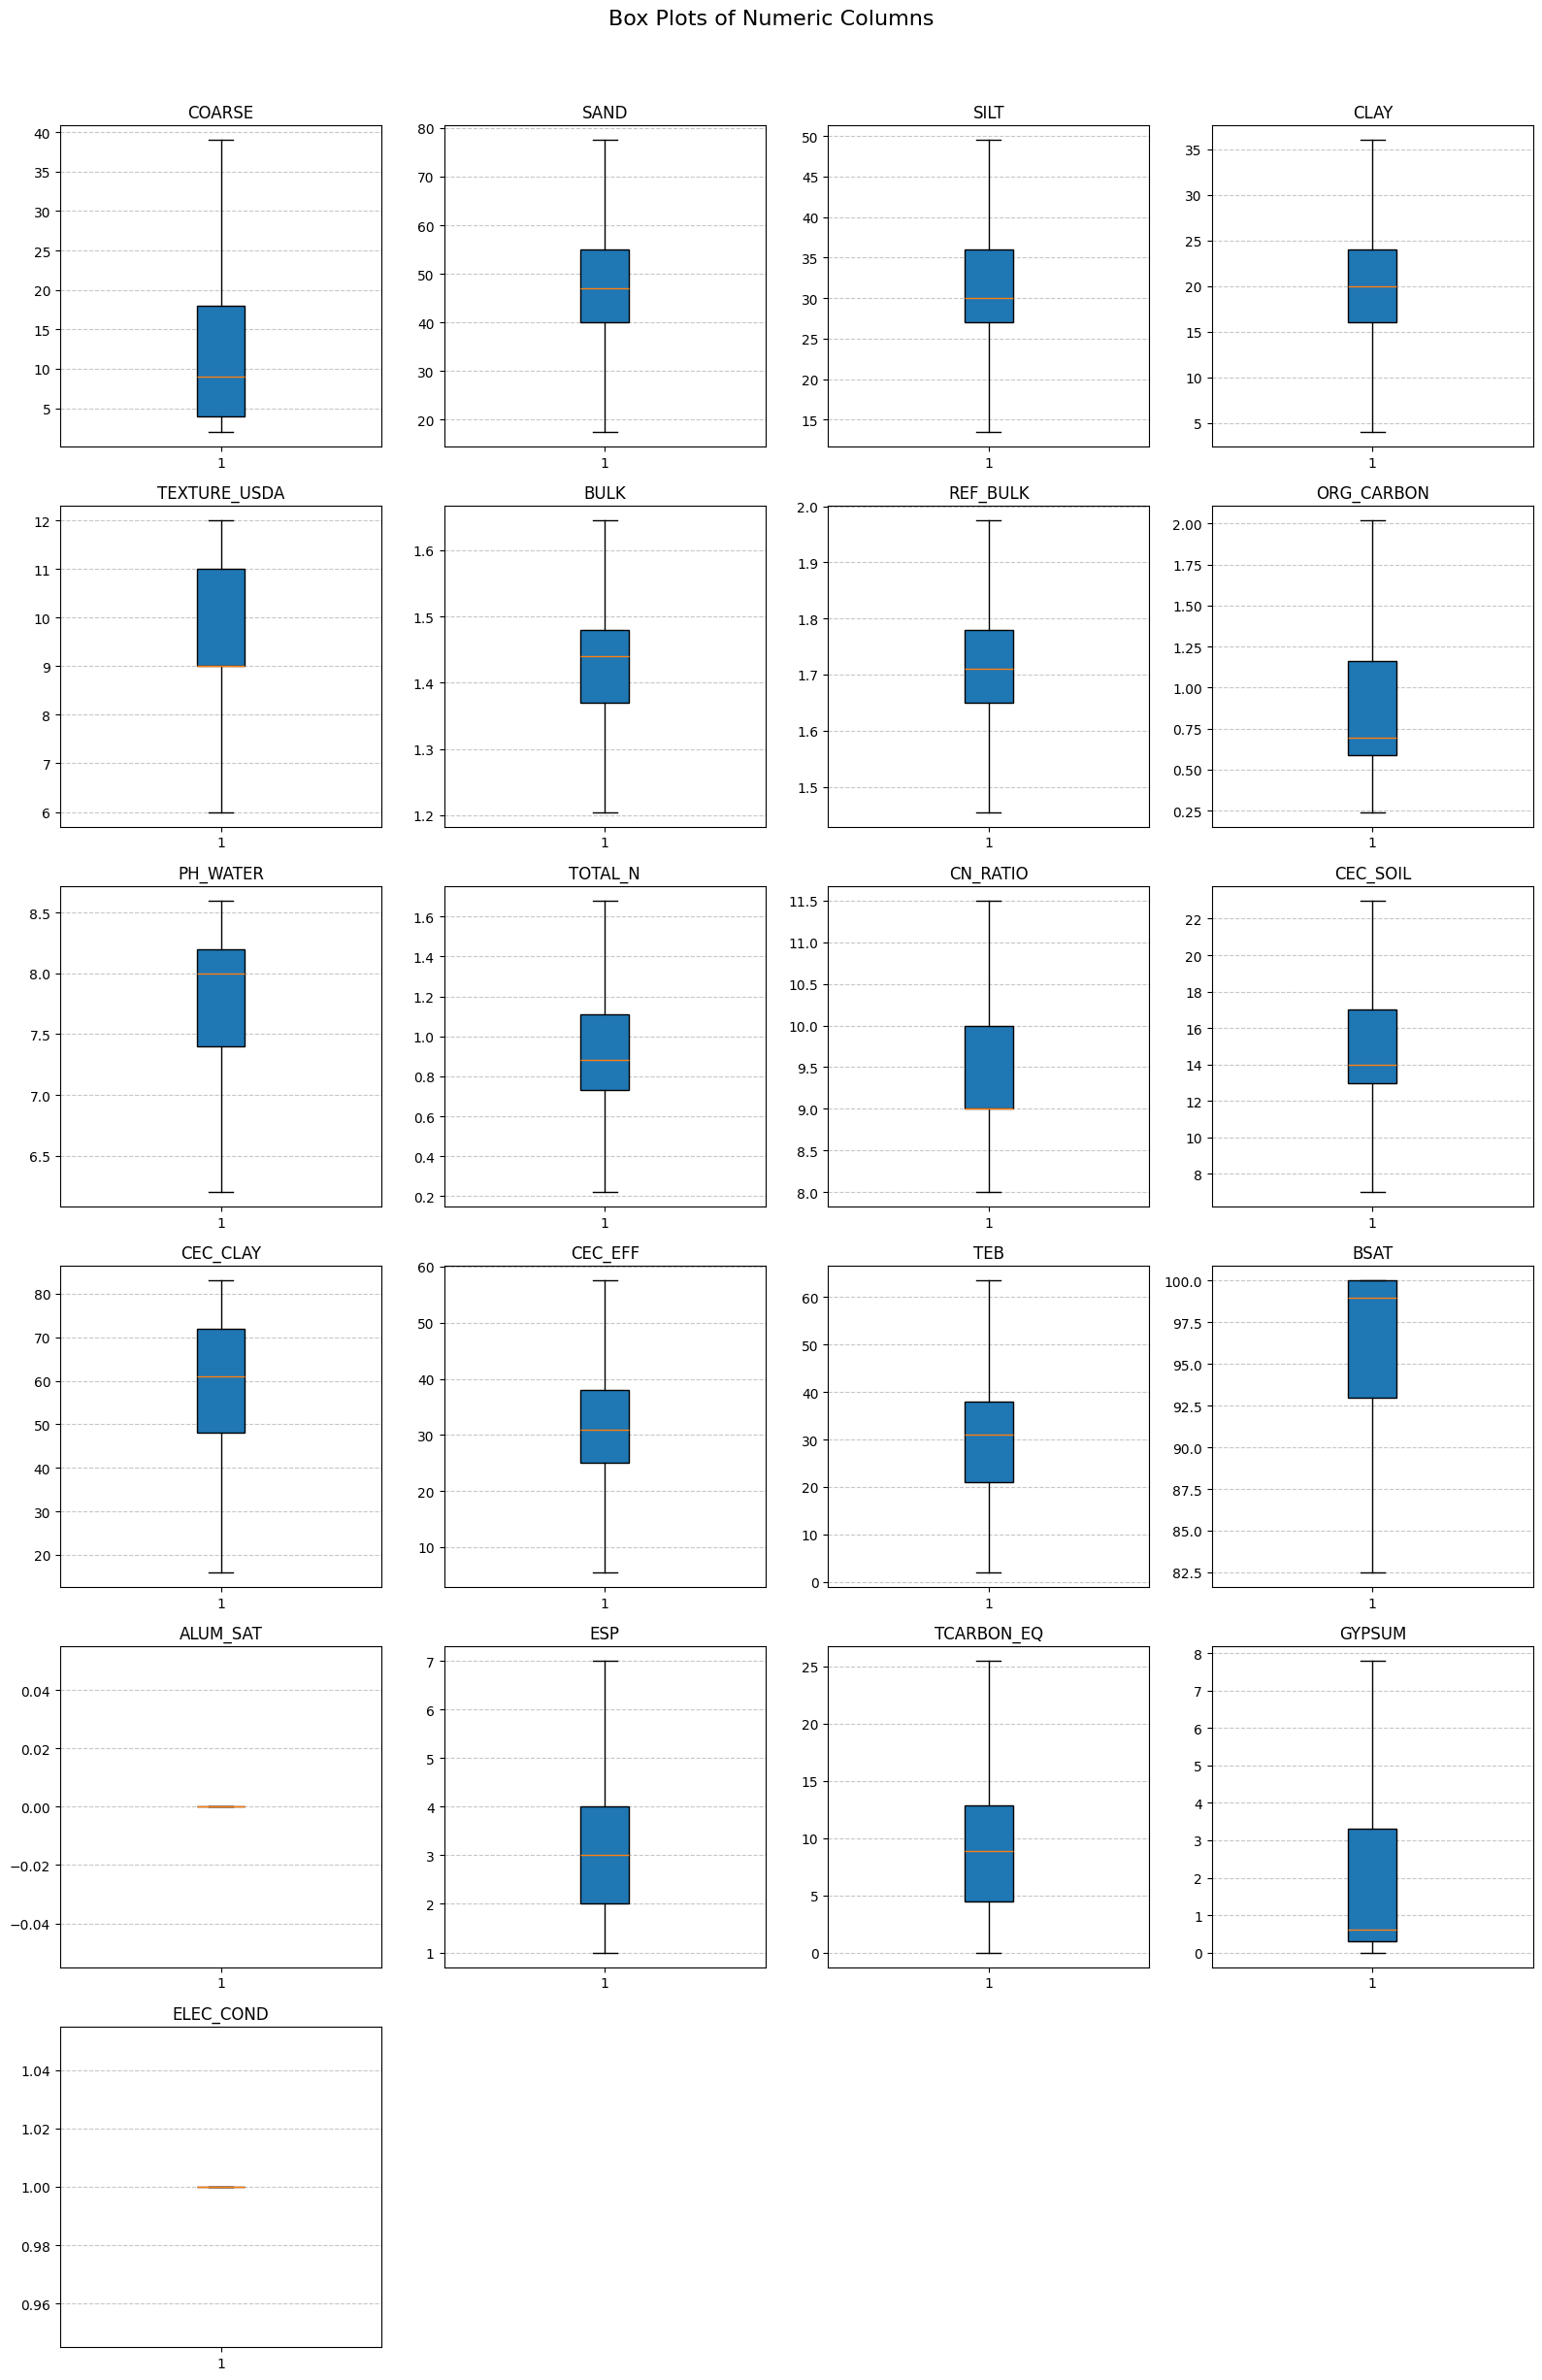

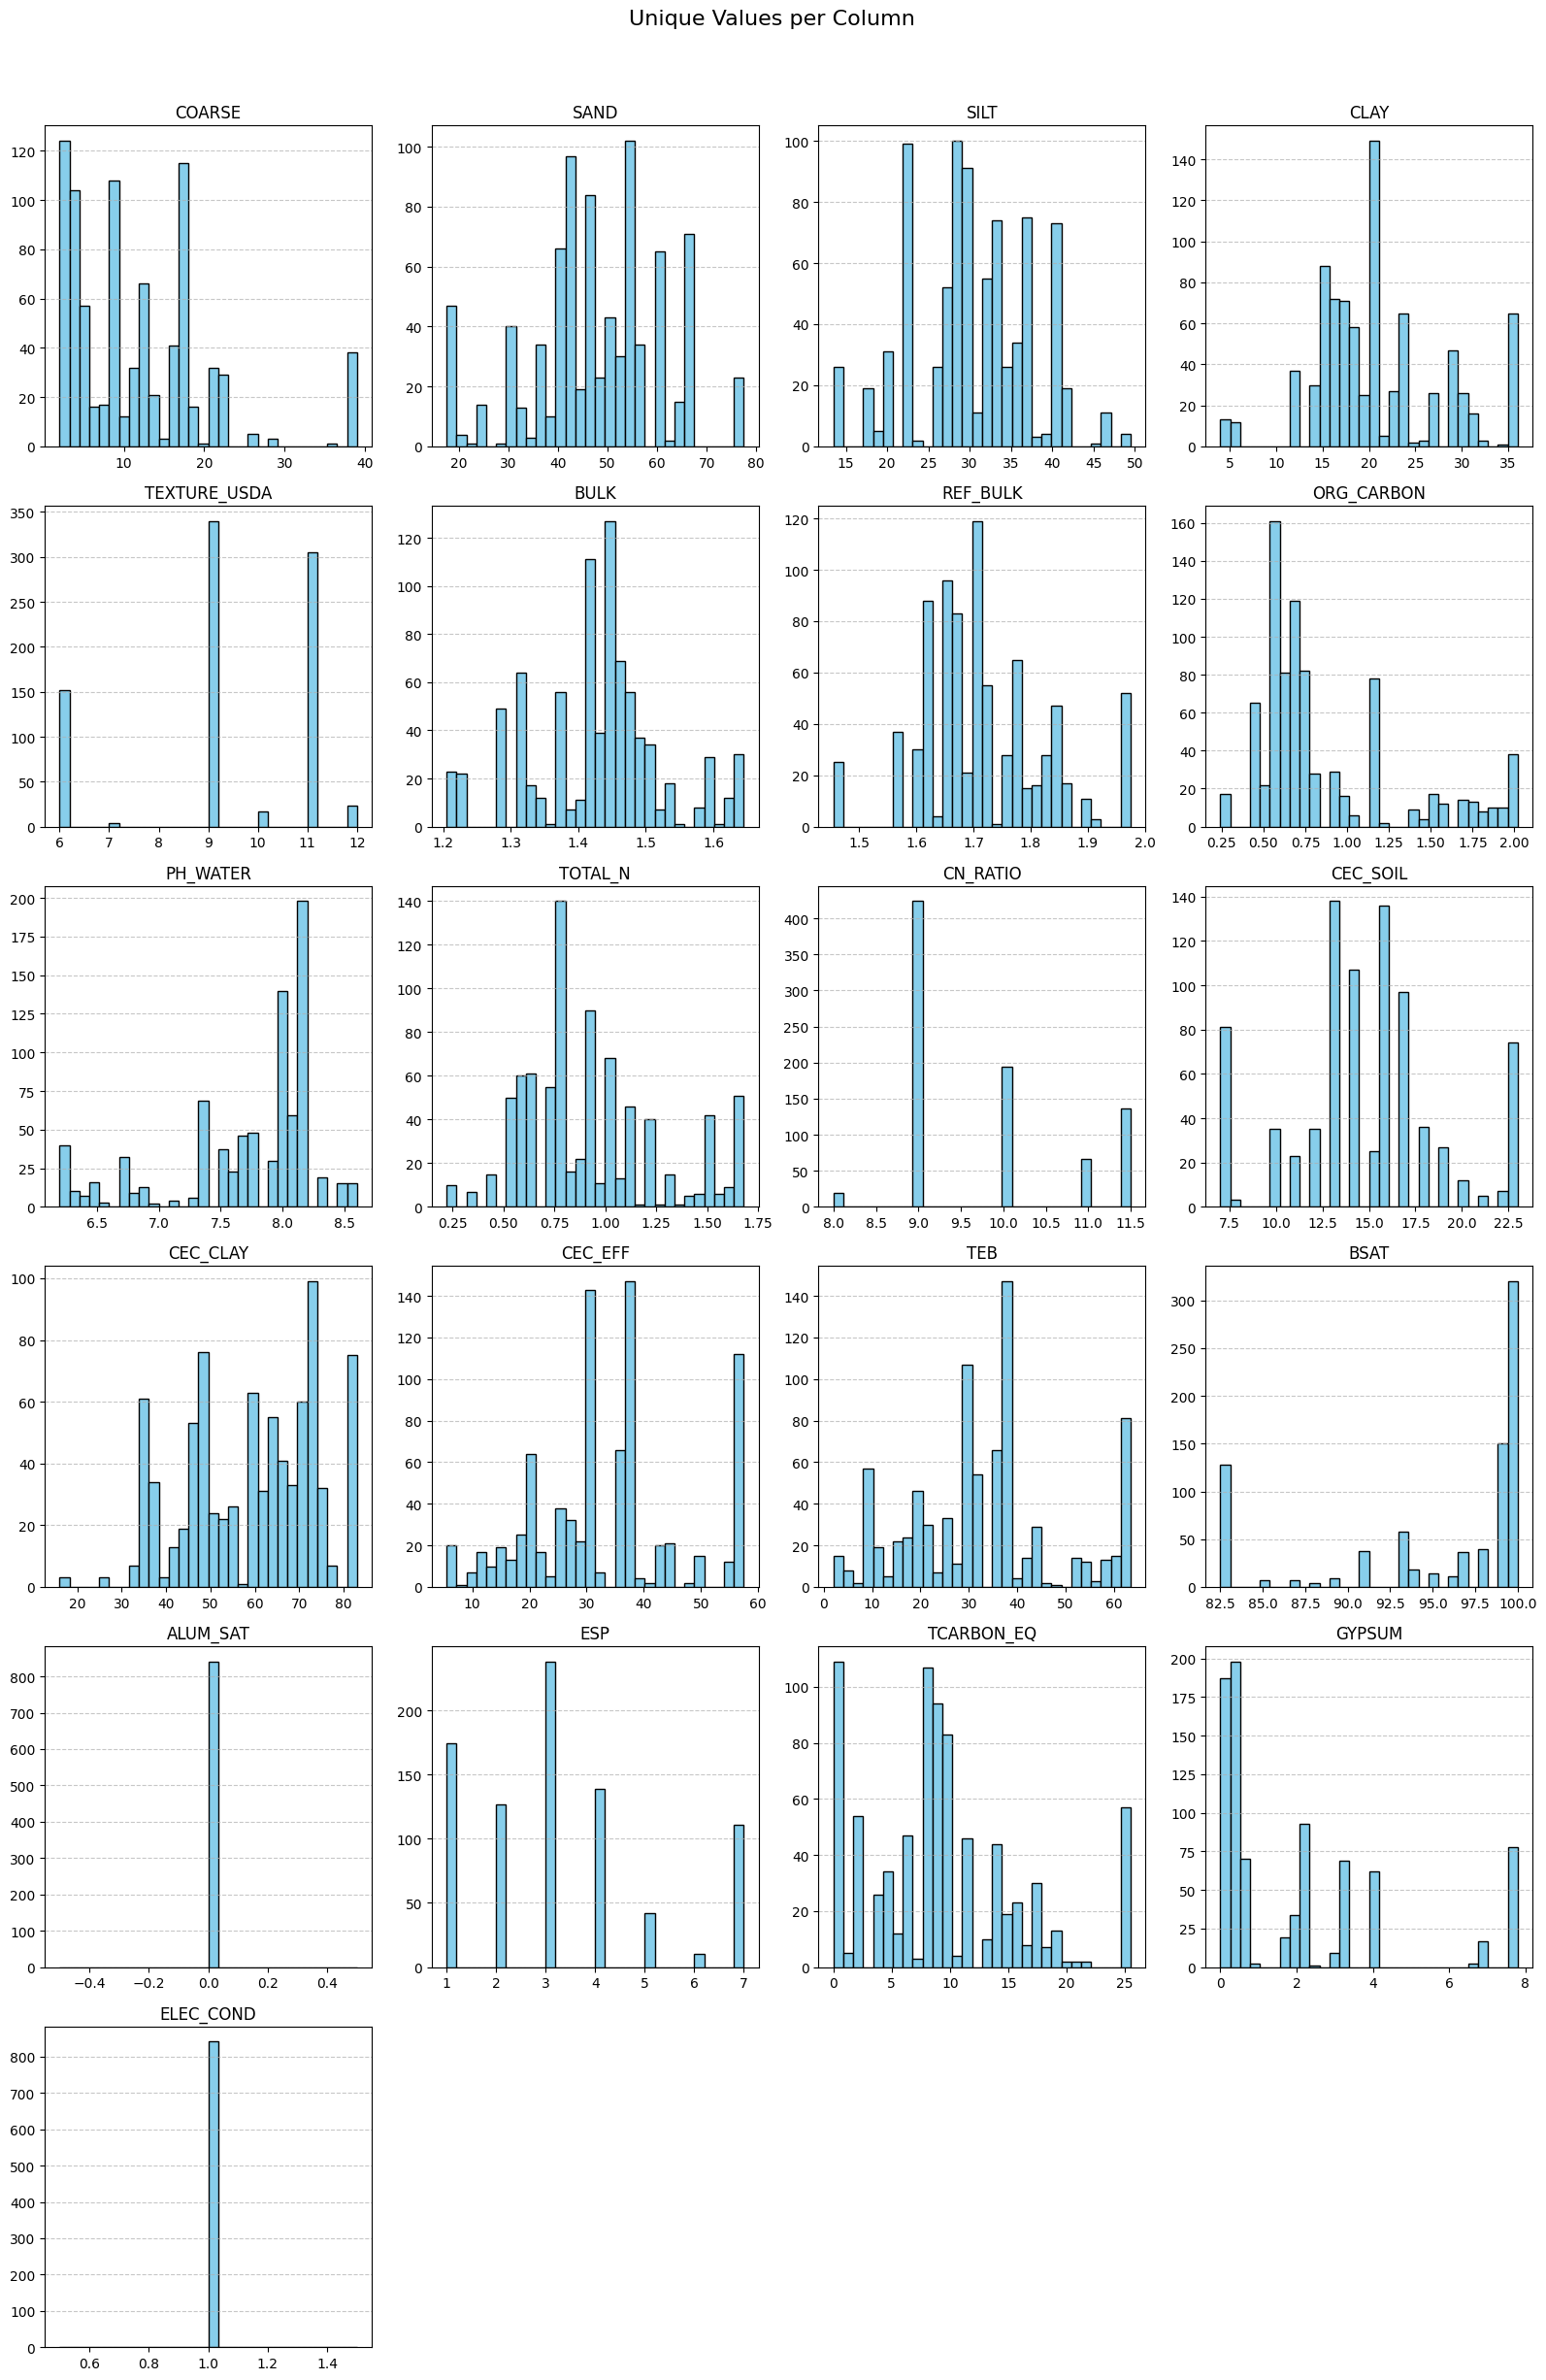

In [75]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
numeric_cols = numeric_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)

plot_box_plots(numeric_cols)
plot_histograms(numeric_cols)

# Correlation analysis

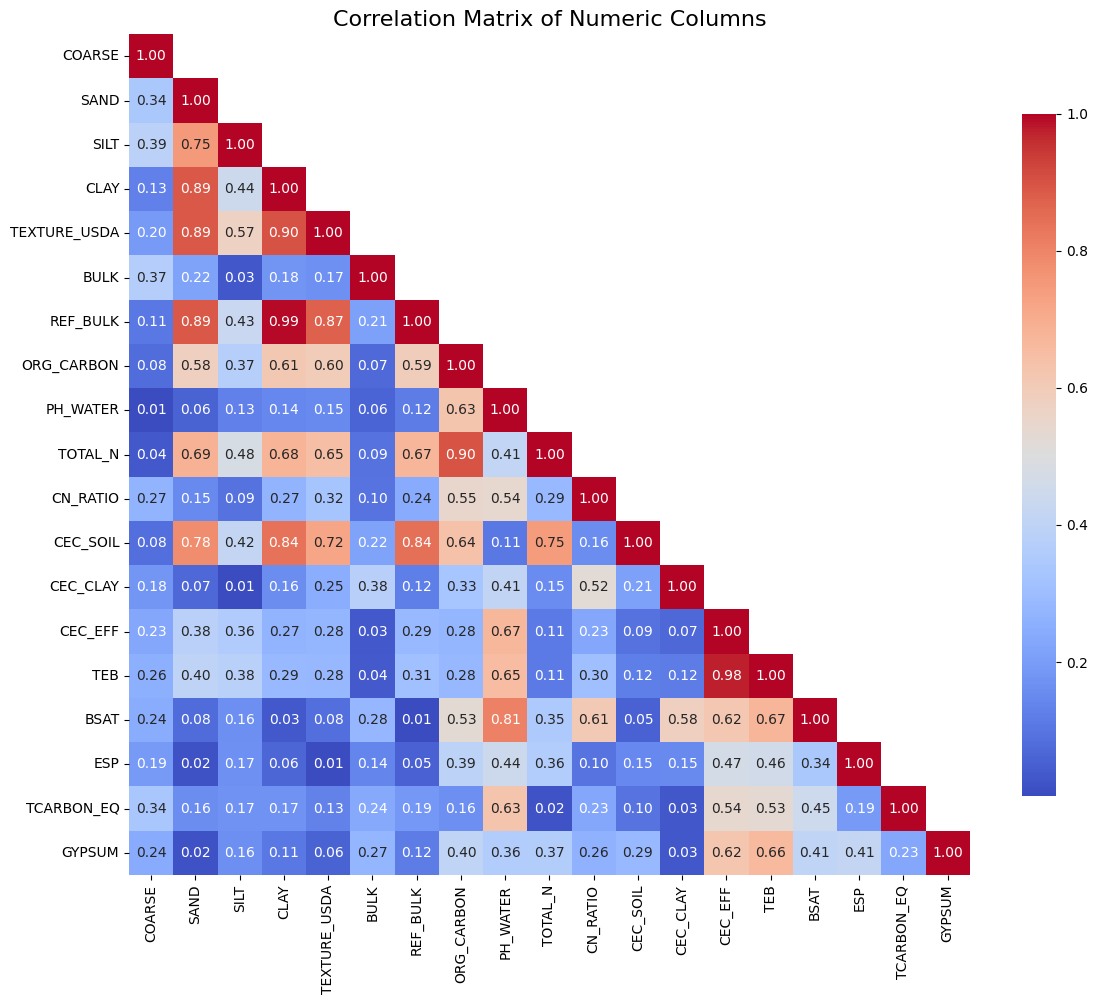

In [102]:

numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1]

# Correlation analysis
correlation_matrix = numeric_cols.corr().abs()

def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)

# Remove Correleated Features 

                COARSE      SAND      SILT      CLAY  TEXTURE_USDA      BULK  \
COARSE        0.000000  0.342325  0.389188  0.125955      0.195179  0.369676   
SAND          0.342325  0.000000  0.748820  0.890650      0.888357  0.217015   
SILT          0.389188  0.748820  0.000000  0.442910      0.573298  0.029102   
CLAY          0.125955  0.890650  0.442910  0.000000      0.900126  0.178332   
TEXTURE_USDA  0.195179  0.888357  0.573298  0.900126      0.000000  0.167108   
BULK          0.369676  0.217015  0.029102  0.178332      0.167108  0.000000   
REF_BULK      0.107302  0.888638  0.430542  0.992310      0.874374  0.208210   
ORG_CARBON    0.081028  0.583436  0.370585  0.613003      0.598063  0.073810   
PH_WATER      0.005117  0.058886  0.127968  0.144480      0.150121  0.059494   
TOTAL_N       0.035929  0.685599  0.478733  0.679045      0.648742  0.091390   
CN_RATIO      0.268962  0.148904  0.092106  0.267536      0.324480  0.095339   
CEC_SOIL      0.084511  0.778684  0.4156

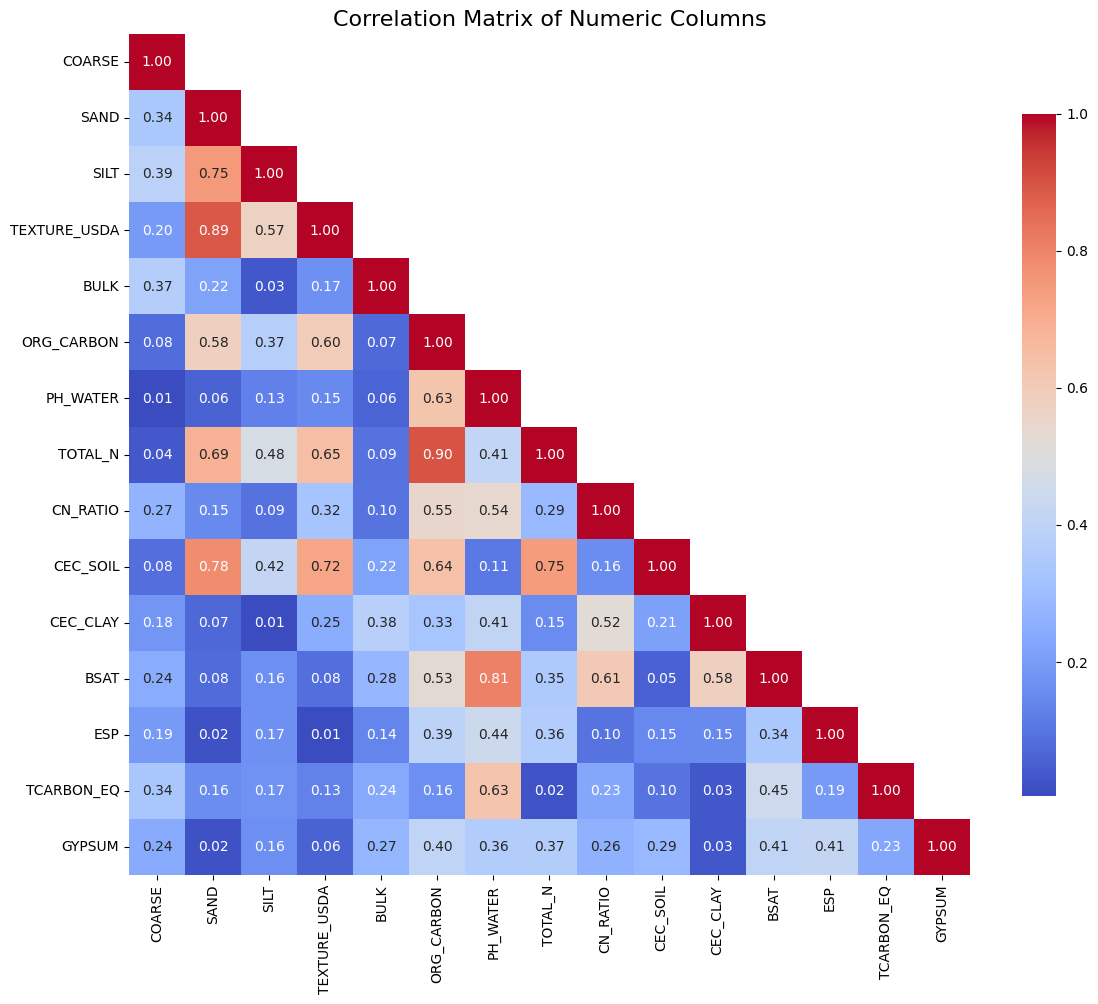

In [ ]:
np.fill_diagonal(correlation_matrix.values, 0)
correlated_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col] > 0.95 )]
new_numeric_cols = numeric_cols.drop(columns=correlated_cols)
plot_correlation_matrix(new_numeric_cols.corr().abs())

# Remerging all columns

In [ ]:
all_cols.update(new_numeric_cols)


# Exporting cleaned dataset

In [78]:

# =========================
# ======= EXPORTING =======
# =========================

# layers_full = layers.merge(smu_ids, on="HWSD2_SMU_ID", how="left")
# print("Merging complete.")



# layers_full.to_csv(r"dataset/soil_full.csv", index=False)
# print("CSV export complete.")

# xarray_layers_full = xarray.Dataset.from_dataframe(layers_full)
# xarray_layers_full.to_netcdf(r"dataset/soil_full.nc")
# print("NetCDF export complete.")

# nc_layers_full = xarray.open_dataset("dataset/soil/HWSD2_Full.nc")
# layers_full = nc_layers_full.to_dataframe().reset_index(drop=True)
# print(layers_full.head())
